In [1]:
import sys
import random

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import NBS
import RSD

In [2]:
# U[0 1] Distribution
# Takes num items
# Returns np.ndarray of shape (num_items,) of values drawn from U[0 1]
def uni_0_1(num_items):
    bids = np.zeros(num_items)
    for b in range(num_items):
        bids[b] = np.random.uniform(0,1)
    return bids

In [3]:
# Quadratic Distribution
# Takes num items
# Returns np.ndarray of shape (num_items,) of values drawn from Quadratic Distribution
def quadratic(num_items):
    bids = np.zeros(num_items)
    for b in range(num_items):
        bids[b] = math.sqrt(np.random.uniform(0,1))
    return bids

In [4]:
# Square Root Distribution
# Takes num items
# Returns np.ndarray of shape (num_items,) of values drawn from Square Root Distribution
def sqrt(num_items):
    bids = np.zeros(num_items)
    for b in range(num_items):
        bids[b] = (np.random.uniform(0,1))**2
    return bids

In [5]:
# Preferential Attachment Agent Values
# Takes number of agents and items and probablity of uniform values for agents, returns 2-Dimensional Value Matrix type np.ndarray
# Agents go one at a time with agent 0's values all random U[0 1]
def pref_att(num_agents, num_items, p=0):
    if (p > 1) or (p < 0):
        raise Exception("p must be in the interval [0,1]")
        
    if num_agents < 1:
        raise Exception("num_agents must be > 1")
        
    if num_items < 1:
        raise Exception("num_items must be > 1")
    
    V = np.zeros((num_agents, num_items))
    V[0] = np.random.rand(num_items)
    for i in range(1, num_agents):
        r = np.random.rand()
        if r <= p:
            V[i] = np.ones(num_items) * (float(1/num_items))
        else:
            item_degrees = np.sum(V, axis=0)
            total_degrees = np.sum(V)
            for j in range(num_items):
                V[i][j] = float(item_degrees[j]/total_degrees)
    return V

In [6]:
# Takes a 1 x n np.ndarray of probabilities, returns index of selected element
# Invariant: array elements must sum to 1
def select_item(a):
    if type(a) is not np.ndarray:
        raise Exception("select_item: a must be type np.ndarray. Current type: ", type(a))
    
    if not(np.isclose(np.sum(a), 1)):
        raise Exception("select_item: array elements must sum to one. Current a: ", a)
    
    if a.ndim != 1:
        raise Exception("select_item: a must be a one-dimensional array. Current dimensions: ", a.shape)
        
    r = np.random.rand()
    a_sum = 0
        
    for i in range(a.size):
        a_curr = a[i]
        if r < a_curr + a_sum:
            return i
        else:
            a_sum += a_curr
    return i 
        
    

In [7]:
# Like pref_att, but instead of assigning probabilities as values, assigns value of 1 or 0
def pref_att_1(num_agents, num_items, p=0):
    if (p > 1) or (p < 0):
        raise Exception("p must be in the interval [0,1]. Current p: ", p)
        
    if num_agents < 1:
        raise Exception("num_agents must be > 1. Current num_agents: ", num_agents)
        
    if num_items < 1:
        raise Exception("num_items must be > 1. Current num_items: ", num_items)
        
    V = np.zeros((num_agents, num_items))
    for j in range(num_items):
        V[0][j] = np.random.binomial(1,0.5)
        
    if np.sum(V) == 0:
        V[0][random.randint(0, num_items-1)] = 1
    
    for i in range(1, num_agents):
        r = np.random.rand()
        if r <= p:
            V[i] = np.ones(num_items) * (float(1/num_items))
        else:
            item_degrees = np.sum(V, axis=0)
            total_degrees = np.sum(V)
            
#             print("Item Degrees: ", item_degrees, " | Total Degrees: ", total_degrees)
            j = select_item(item_degrees / total_degrees)
            V[i][j] = 1
                    
#     print("V: \n", V)
    return V
    

In [8]:
# Finds max index of array
# Takes 1-D np.ndarray, returns index of max value
def find_max_index(array):
    max_util = 0
    max_index = 0
    for i in range(array.size):
        if array[i] >= max_util:
            max_index = i
            max_util = array[i]
    return max_index

In [9]:
# Returns expected value of agent/item utility matrix determined empirically
# Takes value matrix, optionally number of iterations (default 1000)
def monte_carlo_RDS(V, n=1000):     
    # Check to see that V is type numpy.ndarray
    if not(type(V) == np.ndarray):
        raise Exception("V must be a numpy.ndarray, currently type: ", type(V))
        
    probs = np.zeros(V.shape).astype(float)
    for i in range(n):
        probs = np.add(probs, RSD.RSD(V))
    return np.multiply(V, probs/n)

In [11]:
# Returns size x size matrices that, in theory, should yield an RDS:NBS worst case approximation of size 
# Takes the size of matrix (# of agents and items)
def n_approx_val_generator(size):
    
    eps = sys.float_info.epsilon
    V = np.zeros(shape=(size, size))
    
    V[0][0] = 1
    for i in range(1, size):
        V[i][0] = 1
        V[i][i] = float(1-eps)
    
    return V

In [12]:
# Compares empirical worst-case approximation to theoretical worst case approximation
# Returns np.ndarray size (n-2) of error for matrices size 2 - n
def test_approx(start=2, end=20):
    if end < start:
        raise Exception("'end' must be greater than or equal to 'start'")

    error = np.zeros(end-start)
    for i in range(start, end):
        V = n_approx_val_generator(i)
        wcr = worst_case_ratio(i,i,uni_0_1, V)
#         print("Expected: ", i, " | Actual: ", wcr)
        error[i-start] = i - wcr
    return error


In [13]:
def test_pref(start=2, end=20, p=0):
    if end < start:
        raise Exception("'end' must be greater than or equal to 'start'")
        
    if (p > 1) or (p < 0):
        raise Exception("p must be in the interval [0,1]")
        
    if start < 2:
        raise Exception("start must be > 1")

    wcr = np.zeros(shape=end-start)
    for i in range(start, end):
            V = pref_att(i,i)
            wcr[i-start] = worst_case_ratio(i,i,uni_0_1,V)

    return wcr

In [14]:
def test_pref_1(start=2, end=20, p=0):
    if end < start:
        raise Exception("'end' must be greater than or equal to 'start'")
        
    if (p > 1) or (p < 0):
        raise Exception("p must be in the interval [0,1]")
        
    if start < 2:
        raise Exception("start must be > 1")

    wcr = np.zeros(shape=end-start)
    for i in range(start, end):
            V = pref_att_1(i,i)
            wcr[i-start] = worst_case_ratio(i,i,uni_0_1,V)

    return wcr

In [23]:
# Takes num agents, num items, distribution for agent values to be drawn from, and optionally number of trials
# Returns worst-case ratio 
def worst_case_ratio(num_agents, num_items, distro, V=None, n=1000):
    if V is None:
        V = np.zeros((num_agents, num_items))
        for i in range(num_agents):
            V[i] = distro(num_items)
    else:
        if not((V.shape[0] == num_agents) and (V.shape[1] == num_items)):
            raise Exception("Dimensions of V do not match num_agent x num_items. V dims: ", V.shape)
    if not(type(V) == np.ndarray):
        raise Exception("V must be a numpy.ndarray, currently type: ", type(V))
        
    O = np.zeros(num_agents)
#     for i in range(O.size):
#         O[i] = np.sum(V[i]) / num_agents
    
    P_NBS = NBS.NBS(V,O)
    if P_NBS is None: 
        raise Exception("NBS failed, returned None")
        
    U_NBS = np.sum(np.multiply(V, NBS.NBS(V, O)), axis=1)
    U_RDS = np.sum(monte_carlo_RDS(V,n), axis=1)
    
    U_ratio = np.divide(U_NBS, U_RDS)
    return np.amax(U_ratio)

In [24]:
# Preferential attachment algorithm. First student's values are all drawn from U[0 1] distribution
# For each student following: 
#     student has same values as above
#     for each item student has value for, value will instead be drawn from U[0 1] distrubution with probability p
# 
# Takes num_agents, num_items, p, returns 2-d np.ndarray value matrix
def pref_swap(num_agents, num_items, p=0):
    if (p > 1) or (p < 0):
        raise Exception("p must be in the interval [0,1]. Current p: ", p)
        
    if num_agents < 1:
        raise Exception("num_agents must be > 1. Current num_agents: ", num_agents)
        
    if num_items < 1:
        raise Exception("num_items must be > 1. Current num_items: ", num_items)
        
    V = np.zeros(shape=(num_agents, num_items))
    
    # creating first student
    V[0] = np.random.rand(num_items)
    
    # creating rest students
    for i in range(1, num_agents):
        V[i] = V[i-1]
        for j in range(num_agents):
            r = np.random.rand()
            if r < p:
                V[i][j] = np.random.rand()
    
    return V

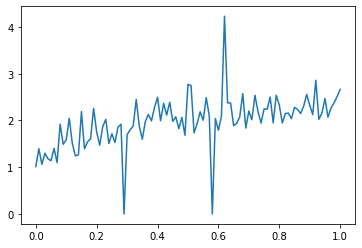

In [36]:
# trials = 100
# wcr_sums = np.zeros(101)
# for i in range(trials):
Q = np.linspace(0,1,101)
wcr = np.zeros(101)
for q in Q:
#     print(q*100)
    wcr[int(q*100)] =  worst_case_ratio(10, 10, uni_0_1, V=pref_swap(10, 10, q))
#     wcr_sums = np.add(wcr_sums, wcr)
plt.figure()
plt.plot(Q, wcr)


In [ ]:
n = test_pref()
for i in range(2, 20):
    print("WCR for size (", i, ", ", i, "): ", n[i-2])